In [141]:
from zipline import run_algorithm
from zipline.algorithm import TradingAlgorithm
from zipline.api import order, symbol, set_commission, record, order_target, order_target_percent, get_datetime, schedule_function, date_rules, time_rules
from zipline.algorithm import TradingAlgorithm
from zipline.finance.commission import PerTrade
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyfolio as pf
import pytz
from zipline.utils.calendar_utils import get_calendar
import calendar
import quantstats as qs
import warnings
import sys,logging
sys.path.append('../../Scripts/')
#from stats_main import *
from datetime import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
df = pd.read_csv('predicted_signal_optimized.csv', index_col= False)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [143]:
df.signal.value_counts()

 1    225
-1    222
 0    129
Name: signal, dtype: int64

In [144]:
df.to_csv('predicted_signal2.csv')

In [145]:
#def initialize(context):
#    context.asset = symbol('BTC')
#    df = pd.read_csv('predicted_signal2.csv', index_col= False)
#    context.signal = df
#    context.i = -1
#    context.buy, context.short, context.sell, context.highest_price,context.sl, context.ts, context.hold = 0, 0, 0, 0, 0, 0, 0
#    schedule_function(stop_loss, date_rules.every_day(), time_rules.market_close())
#    schedule_function(trailing_stop, date_rules.every_day(), time_rules.market_close())
#    #schedule_function(take_profit, date_rules.every_day(), time_rules.market_close())
#    
#    context.profit = 1.27
#    
#    context.stop_loss = 0.019
#
#    
#def handle_data(context, data):
#    context.i += 1
#   
#    
#    trade_signal = context.signal.signal.iloc[context.i]
#    if trade_signal == 1:
#        order_target_percent(context.asset, 0.5)
#        context.buy += 1
#        record(status = 'buy', signal = 1)
#    elif trade_signal == -1:
#        order_target_percent(context.asset, -0.50)
#        context.sell += 1
#        record(status = 'short', signal = -1)
#    else:
#        record(status = 'hold', signal = 0)
#        context.hold += 1
#        
#        
#    record(price = data.current(context.asset, 'price'),
#           portfolio = context.portfolio.positions[context.asset].cost_basis,
#           buy = context.buy, short = context.sell, stop_loss = context.sl, trail_stop =context.ts,signal = trade_signal,
#           hold = context.hold
#           )    
#
#
#    
#def stop_loss(context, data):
#    price = data.current(context.asset, 'close')
#    if price < (1 - context.stop_loss) * context.portfolio.positions[context.asset].cost_basis:
#        order_target_percent(context.asset, 0)
#        
#        context.sl += 1
#        record(status = 'stop loss', signal = -1)
#        
#        
#def trailing_stop(context, data):
#    price = data.current(context.asset, 'price')
#    context.highest_price = max(context.highest_price, price)
#    take_profit_price = data.current(context.asset, 'price') * context.profit
#    if price > data.history(context.asset, 'price', 90, '1d').mean():
#        context.highest_price = max(context.highest_price, price)
#
#    elif price < context.highest_price * (1 - context.stop_loss):
#        order_target_percent(context.asset, 0, limit_price = take_profit_price)
#        context.ts += 1
#        record(status = 'trailing stop', signal = -1)
#        context.highest_price = 0
#
#        
#    
#calendar_name = '24/7'
#calendar = get_calendar(calendar_name)
#start_date = pd.Timestamp('2021-09-06', tz='utc')
#end_date = pd.Timestamp('2023-04-04', tz='utc')
#results = run_algorithm(start=start_date,
#                        end=end_date,
#                        initialize=initialize,
#                        handle_data=handle_data,
#                        capital_base=1000000,
#                        data_frequency='daily',
#                        bundle='cryptocompare_daily',
#                        trading_calendar=calendar,
#                        benchmark_returns=None)
#

In [146]:
def stop_loss(context, data):
    price = data.current(context.asset, 'close')
    if price < (1 - context.stop_loss) * context.portfolio.positions[context.asset].cost_basis:
        order(context.asset, 0)
        record(status = 'stop loss')
          
def trailing_stop(context, data):
    price = data.current(context.asset, 'price')
    context.highest_price = max(context.highest_price, price)
    take_profit_price = data.current(context.asset, 'price') * context.profit
    if price > data.history(context.asset, 'close', 90, '1d').mean():
        context.highest_price = max(context.highest_price, price)

    elif price < context.highest_price * (1 - context.stop_loss):
        order(context.asset, 0, limit_price = take_profit_price)
        record(status = 'trailing stop')
        context.highest_price = 0
        
def take_profit(context, data):
    if context.portfolio.positions[context.asset].amount > 0:
        current_price = data.current(context.asset, 'price')
        cost_basis = context.portfolio.positions[context.asset].cost_basis
        profit = (current_price - cost_basis) / cost_basis
        if profit >= context.profit:
            print("Take profit activated")
            order_target_percent(context.asset, 0)
            record(status='take_profit', signal=0, trade='sell')

def initialize(context):
    context.asset = symbol('BTC')
    context.signal = pd.read_csv('predicted_signal2.csv')
    context.signal = context.signal.set_index('timestamp')
    context.buy, context.short, context.sell, context.highest_price = 0, 0, 0, 0
    schedule_function(stop_loss)
    schedule_function(trailing_stop)
    schedule_function(take_profit)
    context.profit = 1.27
    context.stop_loss = 0.019
    context.dt = pd.Timestamp('2021-09-08', tz = 'utc')
    
    
def handle_data(context, data):
    dt_str = context.dt.strftime('%Y-%m-%d')
    try:
        trade_signal = context.signal.signal.loc[dt_str]
    except KeyError:
        trade_signal = 0
    
    if trade_signal == 1:
        order_target_percent(context.asset, 0.5)
        record(status = 'buy', signal = 1, trade = 'buy')
    elif trade_signal == -1:
        order_target_percent(context.asset, -0.5)
        record(status = 'short', signal = -1, trade = 'sell')
    else:
        record(status = 'hold', signal = 0)
        
    context.dt += pd.Timedelta(days=1)
    record(price = data.current(context.asset, 'price'),portfolio = context.portfolio.positions[context.asset].cost_basis,)    
    
calendar_name = '24/7'
calendar = get_calendar(calendar_name)
start_date = pd.Timestamp('2021-09-06', tz='utc')
end_date = pd.Timestamp('2023-04-04', tz='utc')
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=1000000,
                        data_frequency='daily',
                        bundle='cryptocompare_daily',
                        trading_calendar=calendar,
                        benchmark_returns=None)

In [147]:
total_trades = len(results[results['status'] == 'buy']) + len(results[results['status'] == 'short'])
daily_trades = total_trades / len(results)
print('Total trades: ', total_trades)
print('Daily trades: ', daily_trades)

Total trades:  271
Daily trades:  0.4704861111111111


In [148]:
#total_trades = results.short[-1] + results.buy[-1] + results.stop_loss[-1] + results.trail_stop[-1]
#daily_trades = total_trades / len(results)
#print('Total trades: ', total_trades)
#print('Daily trades: ', daily_trades)

In [149]:
results

,period_open,period_close,longs_count,long_value,pnl,capital_used,orders,shorts_count,transactions,positions,...,excess_return,sortino,max_drawdown,sharpe,algo_volatility,benchmark_period_return,benchmark_volatility,trading_days,period_label,algorithm_period_return
2021-09-06 23:59:00+00:00,2021-09-06 00:00:00+00:00,2021-09-06 23:59:00+00:00,0,0.0,0.000000,0.000000e+00,"[{'id': 'f9a008ba8ef045f2afa264bdddcf3297', 'd...",0,[],[],...,0.0,NaN,0.000000,NaN,NaN,0.0,NaN,1,2021-09,0.000000
2021-09-07 23:59:00+00:00,2021-09-07 00:00:00+00:00,2021-09-07 23:59:00+00:00,0,0.0,-210.862395,4.214959e+05,"[{'id': 'f9a008ba8ef045f2afa264bdddcf3297', 'd...",1,"[{'amount': -9, 'dt': 2021-09-07 23:59:00+00:0...","[{'sid': Equity(2 [BTC]), 'amount': -9, 'cost_...",...,0.0,-11.224972,-0.000211,-11.224972,0.002367,0.0,0.0,2,2021-09,-0.000211
2021-09-08 23:59:00+00:00,2021-09-08 00:00:00+00:00,2021-09-08 23:59:00+00:00,0,0.0,7022.702275,4.605041e+04,"[{'id': '15c549667c194131b30a8f4fea44c802', 'd...",1,"[{'amount': -1, 'dt': 2021-09-08 23:59:00+00:0...","[{'sid': Equity(2 [BTC]), 'amount': -10, 'cost...",...,0.0,296.141560,-0.000211,8.755683,0.065365,0.0,0.0,3,2021-09,0.006812
2021-09-09 23:59:00+00:00,2021-09-09 00:00:00+00:00,2021-09-09 23:59:00+00:00,0,0.0,-3194.000000,0.000000e+00,[],1,[],"[{'sid': Equity(2 [BTC]), 'amount': -10, 'cost...",...,0.0,9.089476,-0.003172,3.340427,0.068667,0.0,0.0,4,2021-09,0.003618
2021-09-10 23:59:00+00:00,2021-09-10 00:00:00+00:00,2021-09-10 23:59:00+00:00,0,0.0,15397.500000,0.000000e+00,[],1,[],"[{'sid': Equity(2 [BTC]), 'amount': -10, 'cost...",...,0.0,42.387186,-0.003172,8.076263,0.118463,0.0,0.0,5,2021-09,0.019015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 23:59:00+00:00,2023-03-31 00:00:00+00:00,2023-03-31 23:59:00+00:00,1,14523417.9,223859.230355,-2.849153e+04,"[{'id': '69da1bb330134d67b3863e5d25da5153', 'd...",0,"[{'amount': 1, 'dt': 2023-03-31 23:59:00+00:00...","[{'sid': Equity(2 [BTC]), 'amount': 510, 'cost...",...,0.0,15.710395,-0.052379,6.342961,0.238693,0.0,0.0,572,2023-03,27.877965
2023-04-01 23:59:00+00:00,2023-04-01 00:00:00+00:00,2023-04-01 23:59:00+00:00,1,14517303.0,-6114.900000,0.000000e+00,"[{'id': '95b163e028b24d49bdebf9df0bab544e', 'd...",0,[],"[{'sid': Equity(2 [BTC]), 'amount': 510, 'cost...",...,0.0,15.695697,-0.052379,6.336096,0.238520,0.0,0.0,573,2023-04,27.871850
2023-04-02 23:59:00+00:00,2023-04-02 00:00:00+00:00,2023-04-02 23:59:00+00:00,0,0.0,-156389.384460,2.865160e+07,"[{'id': '95b163e028b24d49bdebf9df0bab544e', 'd...",1,"[{'amount': -1017, 'dt': 2023-04-02 23:59:00+0...","[{'sid': Equity(2 [BTC]), 'amount': -507, 'cos...",...,0.0,15.646415,-0.052379,6.317425,0.238431,0.0,0.0,574,2023-04,27.715461
2023-04-03 23:59:00+00:00,2023-04-03 00:00:00+00:00,2023-04-03 23:59:00+00:00,0,0.0,190976.760000,0.000000e+00,[],1,[],"[{'sid': Equity(2 [BTC]), 'amount': -507, 'cos...",...,0.0,15.663106,-0.052379,6.324163,0.238224,0.0,0.0,575,2023-04,27.906438


In [150]:
results.status.value_counts()

buy              171
stop loss        138
short            100
trailing stop     87
hold              80
Name: status, dtype: int64

In [151]:
#show_rolling_stats(results, 180)

Start date,2021-09-06
End date,2023-04-04
Total months,27
,Backtest
Annual return,334.465%
Cumulative returns,2771.984%
Annual volatility,23.816%
Sharpe ratio,6.30
Calmar ratio,63.85
Stability,0.99
Max drawdown,-5.238%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.24,2022-06-18,2022-06-22,2022-07-02,10
1,4.42,2021-09-21,2021-09-23,2021-09-30,8
2,4.41,2022-11-09,2022-11-10,2022-11-21,9
3,3.28,2022-05-31,2022-06-01,2022-06-06,5
4,3.24,2021-11-26,2021-11-30,2021-12-04,6


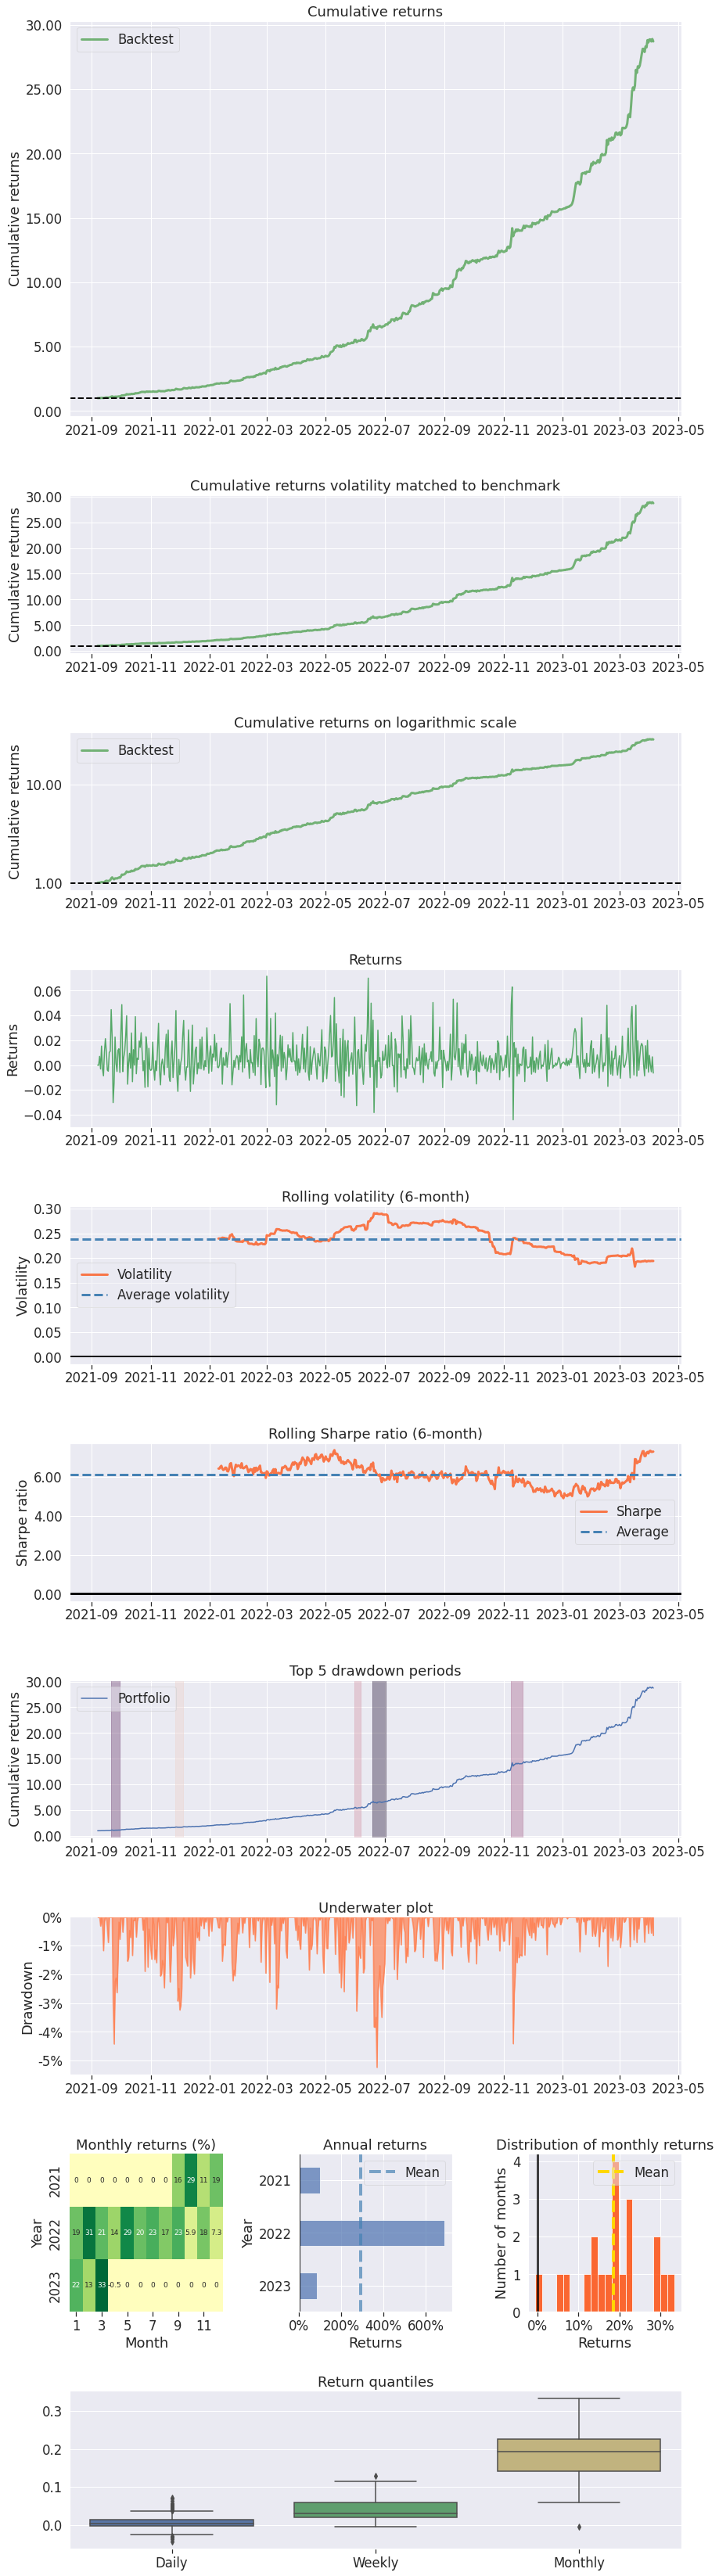

In [152]:
df = pd.DataFrame(results)
pf.create_returns_tear_sheet(df['returns'])

                           Strategy
-------------------------  ----------
Start Period               2021-09-06
End Period                 2023-04-04
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          2,771.98%
CAGR﹪                     335.58%

Sharpe                     6.3
Prob. Sharpe Ratio         100.0%
Smart Sharpe               5.55
Sortino                    15.6
Smart Sortino              13.75
Sortino/√2                 11.03
Smart Sortino/√2           9.72
Omega                      3.24

Max Drawdown               -5.24%
Longest DD Days            13
Volatility (ann.)          23.82%
Calmar                     64.07
Skew                       0.95
Kurtosis                   2.29

Expected Daily %           0.58%
Expected Monthly %         18.28%
Expected Yearly %          206.24%
Kelly Criterion            42.44%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.87%
Expected Shortfall (cVaR)  -1.87%

Max Consecutive Wi

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-06-19,2022-06-22,2022-07-01,13,-5.237893,-3.840863
2,2021-09-22,2021-09-23,2021-09-29,8,-4.422779,-3.029951
3,2022-11-10,2022-11-10,2022-11-20,11,-4.413936,-2.676968
4,2022-06-01,2022-06-01,2022-06-05,5,-3.279156,-2.258926
5,2021-11-27,2021-11-30,2021-12-03,7,-3.240785,-3.068832


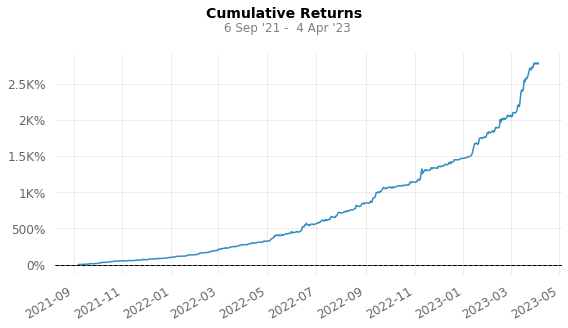

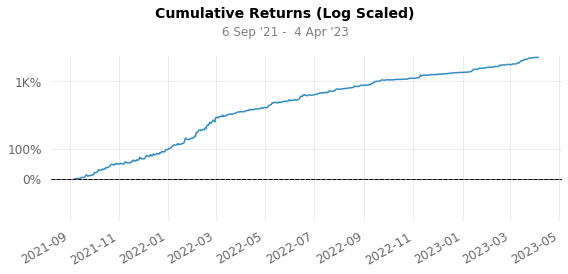

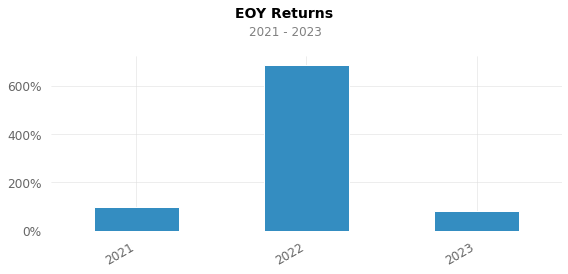

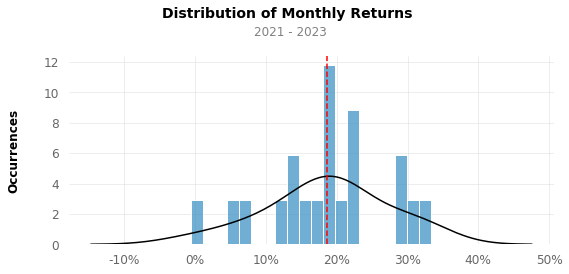

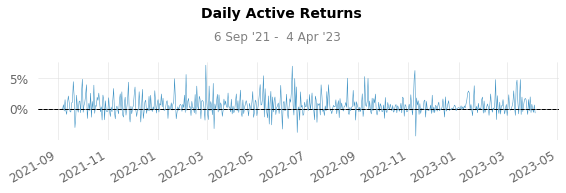

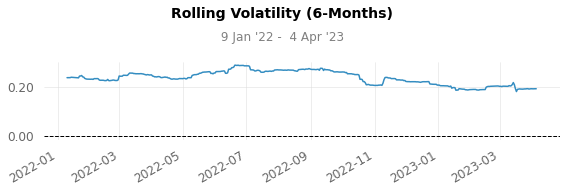

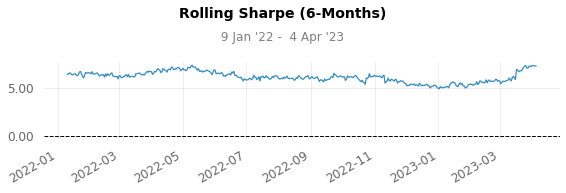

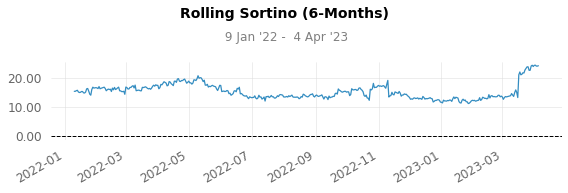

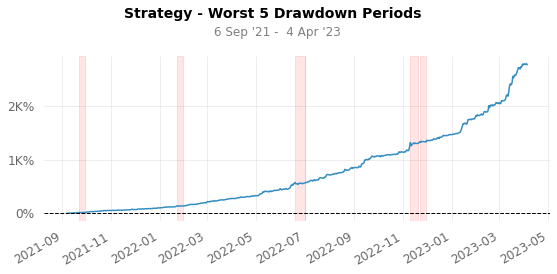

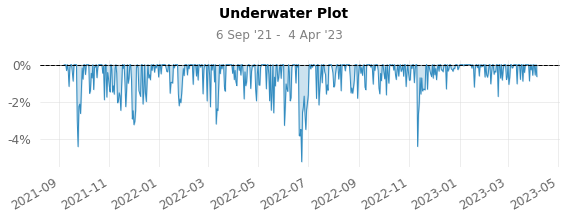

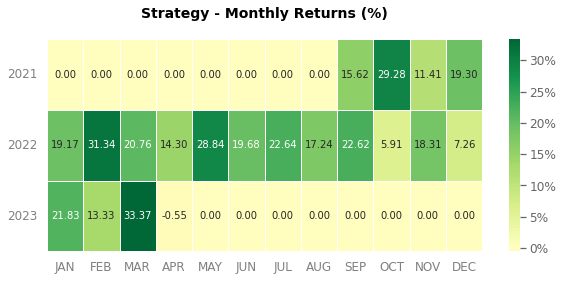

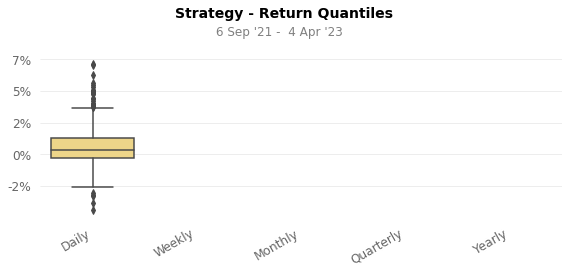

In [153]:
results.index = pd.to_datetime(results.index).tz_localize(None)

qs.reports.full(results['returns'])

In [154]:
#qs.reports.html(results['returns'])